In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = 'fruits_dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 9124


In [5]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Avocado (2)


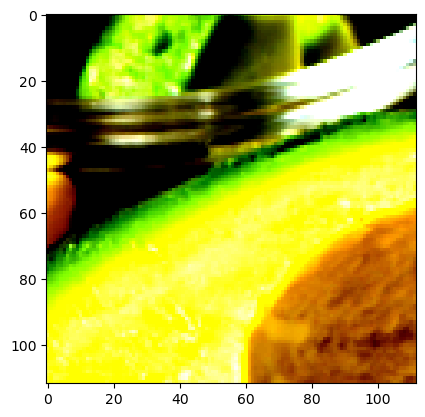

In [7]:
show_image(*dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [9]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(7756, 456, 912)

In [10]:
batch_size = 10
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


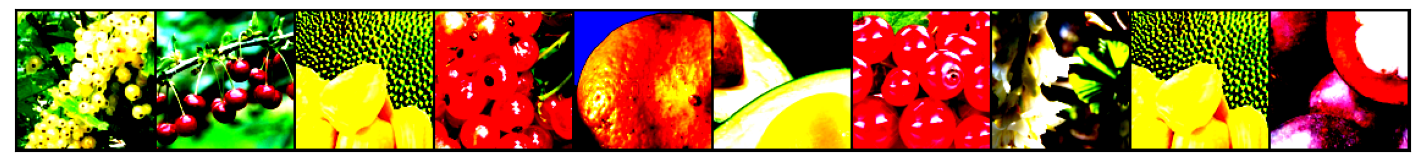

In [11]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [12]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*112*112
output_size = 55

In [16]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        return F.log_softmax(X, dim=1)

In [17]:
# Model print
num_classes = 55
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [18]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([10, 3, 112, 112])
out.shape: torch.Size([10, 55])
out[0]: tensor([-3.9676, -3.9785, -4.0547, -4.0840, -4.0095, -4.0232, -3.9503, -4.0544,
        -4.0013, -3.9489, -4.0278, -3.9529, -3.9561, -3.9824, -4.0331, -3.9607,
        -4.0014, -3.9984, -3.9491, -4.0444, -3.9589, -4.0229, -3.9723, -4.0353,
        -4.0106, -3.9849, -3.9639, -4.0021, -4.0051, -3.9721, -4.0502, -4.0498,
        -3.9998, -3.9485, -3.9986, -4.0324, -3.9681, -3.9985, -4.0324, -3.9877,
        -4.0876, -4.0450, -4.0366, -3.9470, -4.0171, -4.0273, -4.0835, -4.0132,
        -3.9807, -4.0460, -4.0462, -4.0402, -4.0346, -4.0259, -4.0389],
       grad_fn=<SelectBackward0>)


In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=55, bias=True)
)

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(model, device)

In [22]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 4.008056640625, 'val_acc': 0.04565217345952988}]

In [23]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 30
opt_func = torch.optim.SGD
lr = 0.001

912


In [24]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.9982, val_loss: 3.9896, val_acc: 0.0870


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.9609, val_loss: 3.9222, val_acc: 0.1239


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7897, val_loss: 3.6303, val_acc: 0.2109


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4478, val_loss: 3.3371, val_acc: 0.2971


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.2656, val_loss: 3.2440, val_acc: 0.3188


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.1675, val_loss: 3.1877, val_acc: 0.3391


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.0900, val_loss: 3.1309, val_acc: 0.3326


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.0205, val_loss: 3.1001, val_acc: 0.3493


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.9606, val_loss: 3.0231, val_acc: 0.3630


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.9043, val_loss: 2.9730, val_acc: 0.4123


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [10], train_loss: 2.8596, val_loss: 2.9830, val_acc: 0.3899


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [11], train_loss: 2.8179, val_loss: 3.0011, val_acc: 0.4080


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [12], train_loss: 2.7819, val_loss: 3.0153, val_acc: 0.3812


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [13], train_loss: 2.7386, val_loss: 2.9420, val_acc: 0.4188


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [14], train_loss: 2.7085, val_loss: 2.8468, val_acc: 0.4565


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [15], train_loss: 2.6623, val_loss: 2.8482, val_acc: 0.4572


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [16], train_loss: 2.6294, val_loss: 2.8172, val_acc: 0.4551


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [17], train_loss: 2.5959, val_loss: 2.8524, val_acc: 0.4616


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [18], train_loss: 2.5635, val_loss: 2.8413, val_acc: 0.4681


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [19], train_loss: 2.5223, val_loss: 2.8207, val_acc: 0.4768


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [20], train_loss: 2.4846, val_loss: 2.7775, val_acc: 0.4783


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [21], train_loss: 2.4390, val_loss: 2.8009, val_acc: 0.4696


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [22], train_loss: 2.4053, val_loss: 2.8654, val_acc: 0.4971


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [23], train_loss: 2.3667, val_loss: 2.7453, val_acc: 0.5196


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [24], train_loss: 2.3259, val_loss: 2.7362, val_acc: 0.5174


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [25], train_loss: 2.2831, val_loss: 2.7195, val_acc: 0.5377


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [26], train_loss: 2.2431, val_loss: 2.6007, val_acc: 0.5543


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [27], train_loss: 2.1923, val_loss: 2.7215, val_acc: 0.5022


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [28], train_loss: 2.1493, val_loss: 2.7184, val_acc: 0.5043


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [29], train_loss: 2.1078, val_loss: 2.6387, val_acc: 0.5478


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

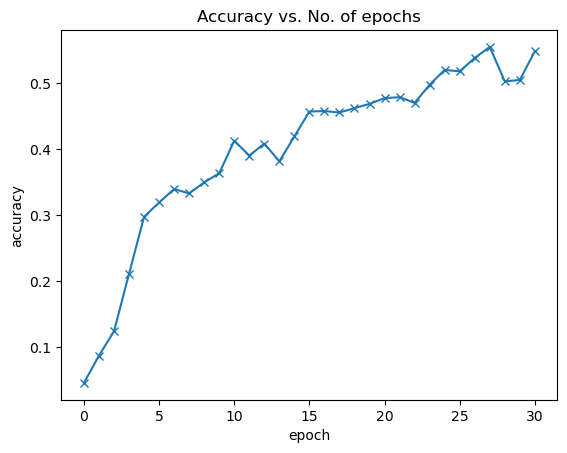

In [26]:
plot_accuracies(history)

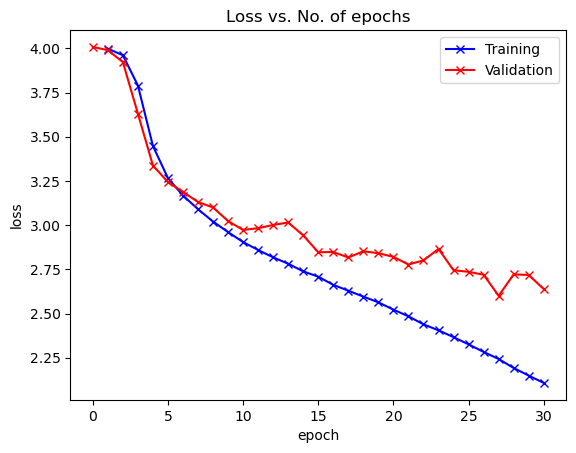

In [27]:
plot_losses(history)

In [28]:
evaluate(model, test_loader)

{'val_loss': 2.53109073638916, 'val_acc': 0.560869574546814}